# **PREDICTION OF MILLING MACHINE BEHAVIOR**

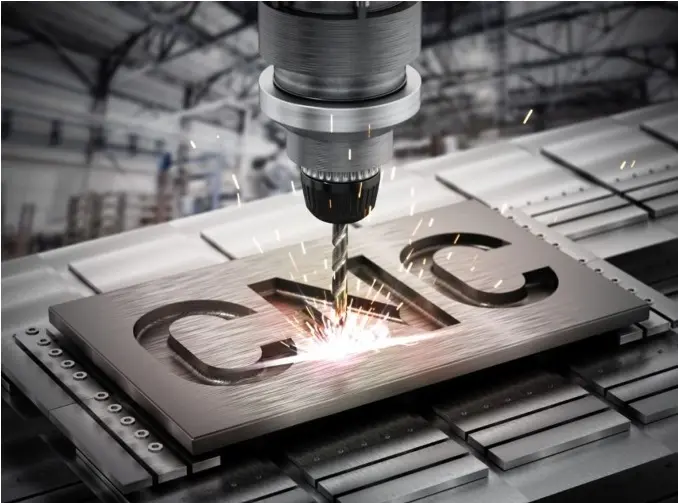

## Structure of the Synthetic Dataset


### **Descripción General**
- **Tipo de Conjunto de Datos**: Sintético, modelado a partir de una fresadora existente.
- **Tamaño del Conjunto de Datos**: 10,000 puntos de datos.
- **Estructura**: Cada fila representa un punto de datos con 14 características (columnas).

---

### **Características (Columnas)**

1. **UID (Identificador Único)**:
   - Rango: 1 a 10,000.
   - Descripción: Identificador único para cada punto de datos.

2. **Product ID (Identificador del Producto)**:
   - Formato: Letra (L, M, H) + Número de serie.
     - **L**: Calidad baja (50% de los productos).
     - **M**: Calidad media (30% de los productos).
     - **H**: Calidad alta (20% de los productos).
   - Descripción: Identifica la variante de calidad del producto y su número de serie.

3. **Type (Tipo de Producto)**:
   - Valores: L, M, H.
   - Descripción: Representa la calidad del producto (baja, media, alta).

4. **Air Temperature [K] (Temperatura del Aire)**:
   - Generación: Proceso de caminata aleatoria normalizado con una desviación estándar de 2 K alrededor de 300 K.
   - Descripción: Temperatura del aire en Kelvin.

5. **Process Temperature [K] (Temperatura del Proceso)**:
   - Generación: Proceso de caminata aleatoria normalizado con una desviación estándar de 1 K, sumado a la temperatura del aire más 10 K.
   - Descripción: Temperatura del proceso en Kelvin.

6. **Rotational Speed [rpm] (Velocidad de Rotación)**:
   - Cálculo: Derivada de una potencia de 2860 W, con ruido distribuido normalmente.
   - Descripción: Velocidad de rotación en revoluciones por minuto (rpm).

7. **Torque [Nm] (Par de Torsión)**:
   - Distribución: Valores distribuidos normalmente alrededor de 40 Nm con una desviación estándar de 10 Nm.
   - Restricción: No hay valores negativos.
   - Descripción: Par de torsión en Newton-metros (Nm).

8. **Tool Wear [min] (Desgaste de la Herramienta)**:
   - Cálculo: Depende de la calidad del producto:
     - **H**: Añade 5 minutos de desgaste.
     - **M**: Añade 3 minutos de desgaste.
     - **L**: Añade 2 minutos de desgaste.
   - Descripción: Tiempo de desgaste de la herramienta en minutos.

9. **Machine Failure (Falla de la Máquina)**:
   - Valores: 0 (sin falla) o 1 (falla).
   - Descripción: Etiqueta que indica si la máquina ha fallado en ese punto de datos debido a cualquiera de los modos de falla.

---

### **Modos de Falla Independientes**

1. **Tool Wear Failure (TWF - Falla por Desgaste de la Herramienta)**:
   - Condición: El desgaste de la herramienta alcanza un valor entre 200 y 240 minutos.
   - Acciones:
     - Reemplazo de la herramienta: 69 veces.
     - Falla de la herramienta: 51 veces.
   - Frecuencia: 120 veces en el conjunto de datos.

2. **Heat Dissipation Failure (HDF - Falla por Disipación de Calor)**:
   - Condición:
     - Diferencia entre la temperatura del aire y la temperatura del proceso < 8.6 K.
     - Velocidad de rotación < 1380 rpm.
   - Frecuencia: 115 veces en el conjunto de datos.

3. **Power Failure (PWF - Falla de Potencia)**:
   - Condición: La potencia (producto del par de torsión y la velocidad de rotación en rad/s) está fuera del rango [3500 W, 9000 W].
   - Frecuencia: 95 veces en el conjunto de datos.

4. **Overstrain Failure (OSF - Falla por Sobreesfuerzo)**:
   - Condición: El producto del desgaste de la herramienta y el par de torsión excede:
     - 11,000 minNm para productos de calidad **L**.
     - 12,000 minNm para productos de calidad **M**.
     - 13,000 minNm para productos de calidad **H**.
   - Frecuencia: 98 veces en el conjunto de datos.

5. **Random Failures (RNF - Fallas Aleatorias)**:
   - Condición: Cada proceso tiene un 0.1% de probabilidad de fallar independientemente de los parámetros.
   - Frecuencia: 5 veces en el conjunto de datos.



## IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split ,KFold
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
import xgboost

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler



## DATA LOADING AND ANALYSIS

Datasets elegido: https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020

In [2]:
df=pd.read_csv('./data/ai4i2020.csv',index_col=0)

In [3]:
df.head(10)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Machine failure          10000 non-null  int64  
 8   TWF                      10000 non-null  int64  
 9   HDF                      10000 non-null  int64  
 10  PWF                      10000 non-null  int64  
 11  OSF                      10000 non-null  int64  
 12  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 1.1+ MB


In [5]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [6]:
df['Machine failure'].value_counts()

Machine failure
0    9661
1     339
Name: count, dtype: int64

Esto nos indica que posteriormente, habrá que aplicar un under resampled para crear nuestro modelo y así balancear estos datos consiguiendo que haya igual de 1 que de 0 en nuestro entrenamiento. También aplicaremos una estratificación en train_test_split para asegurar que haya la misma proporción en train que en test

In [7]:
df['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [8]:
df.groupby('Type')['Machine failure'].sum()

Type
H     21
L    235
M     83
Name: Machine failure, dtype: int64

Visualizamos la desviación de nuestros datos:

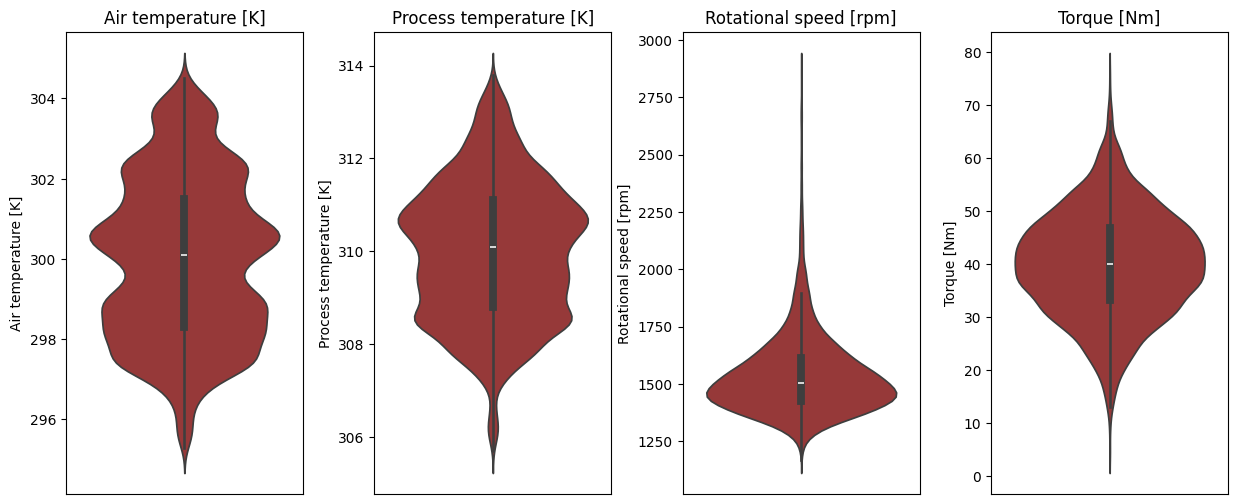

In [9]:
all_data=[df['Air temperature [K]'],df['Process temperature [K]'],df['Rotational speed [rpm]'],df['Torque [Nm]']]
plt.figure(figsize=(15,6))
title_data=['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]']
for i in range(4):
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.subplot(1,4,i+1)
    sns.violinplot(all_data[i],color='brown');
    plt.xticks([])
    plt.title(title_data[i],fontsize=12)


In [10]:
df[df['Rotational speed [rpm]']>2700]

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
51,L47230,L,298.9,309.1,2861,4.6,143,1,0,0,1,0,0
464,L47643,L,297.4,308.7,2874,4.2,118,1,0,0,1,0,0
848,L48027,L,296.4,307.4,2833,5.6,213,1,0,0,1,0,0
1096,L48275,L,296.9,307.5,2721,9.3,18,1,0,0,1,0,0
1392,L48571,L,298.9,310.2,2737,8.8,142,1,0,0,1,0,0
1785,L48964,L,298.3,308.0,2886,3.8,57,1,0,0,1,0,0
3370,L50549,L,301.5,310.9,2760,8.0,15,1,0,0,1,0,0
3868,M18727,M,302.7,311.6,2709,9.7,2,1,0,0,1,0,0
4297,L51476,L,301.8,310.2,2825,5.8,215,1,0,0,1,0,0


Ahora vamos a estudiar los diferentes tipos de fallo, que serán de estudio también para poder ser predichos por un modelo

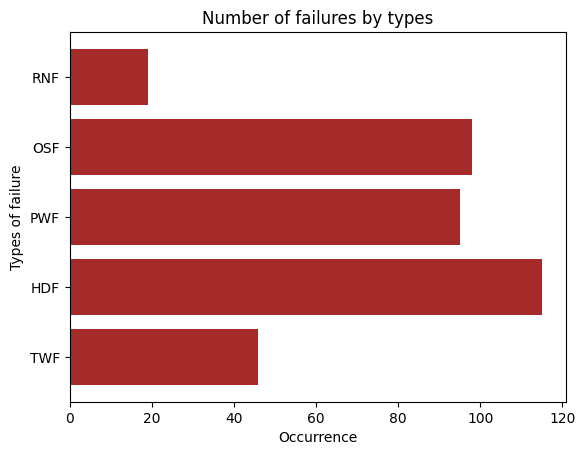

In [11]:
names=['TWF','HDF','PWF','OSF','RNF']
values=[df['TWF'][df['TWF']==1].sum(),df['HDF'][df['HDF']==1].sum(),df['PWF'][df['PWF']==1].sum(),df['OSF'][df['OSF']==1].sum(),df['RNF'][df['RNF']==1].sum()]

plt.barh(names,values,color='brown',)
plt.xlabel("Occurrence")
plt.ylabel("Types of failure")
plt.title("Number of failures by types")
plt.show()


In [12]:
df['TWF'][df['TWF']==1].sum()+df['HDF'][df['HDF']==1].sum()+df['PWF'][df['PWF']==1].sum()+df['OSF'][df['OSF']==1].sum()+df['RNF'][df['RNF']==1].sum()


np.int64(373)

In [13]:
df['Machine failure'][df['Machine failure']==1].sum()

np.int64(339)

In [14]:
df[(df['Machine failure']==0) & ((df['TWF']==1) | (df['HDF']==1) | (df['PWF']==1) | (df['OSF']==1) | (df['RNF']==1))]


,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1222,M16081,M,297.0,308.3,1399,46.4,132,0,0,0,0,0,1
1303,L48482,L,298.6,309.8,1505,45.7,144,0,0,0,0,0,1
1749,H31162,H,298.4,307.7,1626,31.1,166,0,0,0,0,0,1
2073,L49252,L,299.6,309.5,1570,35.5,189,0,0,0,0,0,1
2560,L49739,L,299.3,309.0,1447,50.4,140,0,0,0,0,0,1
3066,M17925,M,300.1,309.2,1687,27.7,95,0,0,0,0,0,1
3453,H32866,H,301.6,310.5,1602,32.3,2,0,0,0,0,0,1
5472,L52651,L,302.7,312.3,1346,61.2,170,0,0,0,0,0,1
5490,L52669,L,302.6,312.1,1499,35.0,215,0,0,0,0,0,1


In [15]:
df[(df['Machine failure']==1) & (df['RNF']==1)]

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
3612,L50791,L,301.7,310.9,1405,46.4,207,1,1,0,0,0,1


Dado que este modo de rotura es independiente a los parámetros usados, a la hora de predecir va a provocar ruido a nuestro modelo, por lo tanto se ha tomado la decisión de eliminar este tipo de fallo. Al ser aleatorios tendremos que asumirlos.

Chequeamos si hay modos de fallo que coincidan:

In [16]:
df[((df['TWF']==1) & (df['HDF']==1)) | ((df['TWF']==1) & (df['PWF']==1)) | ((df['TWF']==1) & (df['OSF']==1)) | ((df['HDF']==1) & (df['PWF']==1)) | ((df['HDF']==1) & (df['OSF']==1)) | ((df['PWF']==1) & (df['OSF']==1))]


,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
70,L47249,L,298.9,309.0,1410,65.7,191,1,0,0,1,1,0
1325,M16184,M,298.8,310.1,1243,74.5,194,1,0,0,1,1,0
1497,L48676,L,298.0,308.7,1268,69.4,189,1,0,0,1,1,0
3855,L51034,L,302.4,311.0,1338,67.6,194,1,0,0,1,1,0
3944,L51123,L,302.3,311.4,1333,66.7,205,1,0,0,1,1,0
4255,L51434,L,302.6,311.0,1284,68.0,114,1,0,1,1,0,0
4343,M19202,M,301.7,309.8,1284,68.2,111,1,0,1,1,0,0
4371,L51550,L,302.0,309.9,1308,57.6,197,1,0,1,0,1,0
4384,L51563,L,301.7,309.5,1298,65.5,229,1,0,1,0,1,0


In [17]:
df['Machine failure'][((df['TWF']==1) & (df['HDF']==1)) | ((df['TWF']==1) & (df['PWF']==1)) | ((df['TWF']==1) & (df['OSF']==1)) | ((df['HDF']==1) & (df['PWF']==1)) | ((df['HDF']==1) & (df['OSF']==1)) | ((df['PWF']==1) & (df['OSF']==1))].count()


np.int64(23)

In [18]:
(23/df['Machine failure'][df['Machine failure']==1].sum())*100

np.float64(6.784660766961652)

Lo que encontramos aquí es que hay diferentes casos (23) en los que se producen fallos mixtos, un 6,78%, lo que habrá que tener en consideración a la hora de predecir el tipo de fallo que ocurre

## FEATURE ENGINEERING

Eliminamos la columna de RNF

In [19]:
df=df.drop(columns='RNF')

Sacamos la variable potencia = torque x rot speed

In [20]:
#potencia_w = torque * (rpm * 2 * np.pi / 60) (para pasarlo a radianes)

df['Power [W]']=df['Torque [Nm]']*(df['Rotational speed [rpm]']*(2*np.pi/60))

In [21]:
#También la variable disipación
df['Disipation']=df['Process temperature [K]']-df['Air temperature [K]']

Aplicamos dummies para poder tener en cuenta los valores de dureza de la herramienta: L (Low),M (Medium) y H (High)

In [22]:
#Probado también con los valores medios de las durezas de cada tipo de herramienta, pero se obtuvo peores resultados:
""" df['Type'].replace('L',600,inplace=True)
df['Type'].replace('M',1000,inplace=True)
df['Type'].replace('H',2000,inplace=True) """

" df['Type'].replace('L',600,inplace=True)\ndf['Type'].replace('M',1000,inplace=True)\ndf['Type'].replace('H',2000,inplace=True) "

In [23]:
df = pd.get_dummies(df, columns=['Type'])

In [24]:
df_aux=df[['Machine failure','TWF','HDF','PWF','OSF']]
df=df.drop(columns=['Machine failure','TWF','HDF','PWF','OSF'])
df['Machine failure']=df_aux['Machine failure']
df['TWF']=df_aux['TWF']
df['HDF']=df_aux['HDF']
df['PWF']=df_aux['PWF']
df['OSF']=df_aux['OSF']



In [25]:
df.head(2)

,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Power [W],Disipation,Type_H,Type_L,Type_M,Machine failure,TWF,HDF,PWF,OSF
UDI,,,,,,,,,,,,,,,,
1,M14860,298.1,308.6,1551,42.8,0,6951.590560,10.5,False,False,True,0,0,0,0,0
2,L47181,298.2,308.7,1408,46.3,3,6826.722724,10.5,False,True,False,0,0,0,0,0


Para la hora de predecir el modo de fallo mediante un modelo de clasificación, será mejor agruparlos en una columna los 4 tipos para tener un único target

## VISUALIZATION

Visualizamos en un primer momento todo el dataframe:

<Axes: >

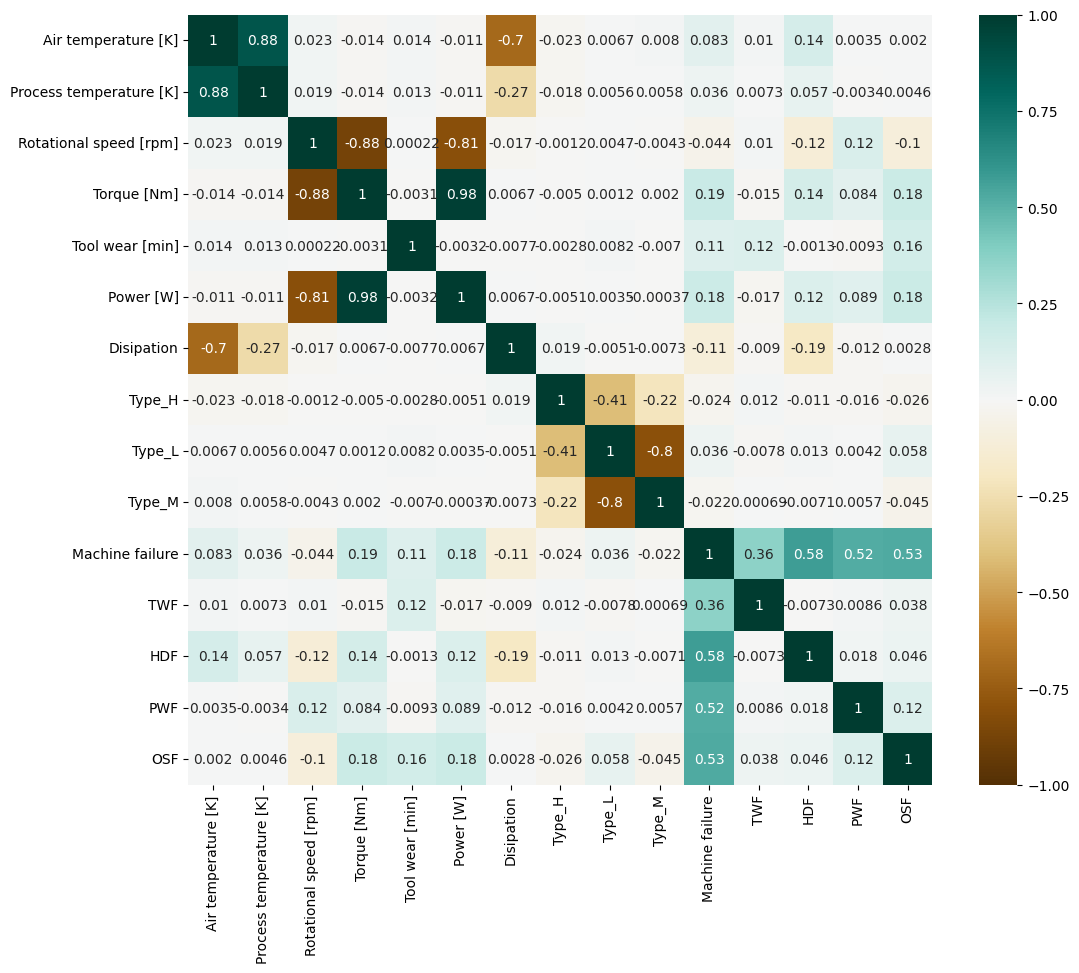

In [26]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='BrBG',vmin=-1,vmax=1)

### ***PRIMER CASO: ESTUDIO DE PREDICCIÓN DE MACHINE FAILURE:***


In [27]:
#sns.pairplot(df.drop(['TWF','HDF','PWF','OSF'],axis=1),hue='Machine failure')

A simple vista se puede ver como en algunas features como valores extremos provocan el fallo. Estas son Rotational speed, torque (tanto por debajo como por arriba) y por lógica la potencia (ya que se obtiene a partir de estas dos) y Tool wear que esta se da más cuando alcanza valores altos.

<Axes: >

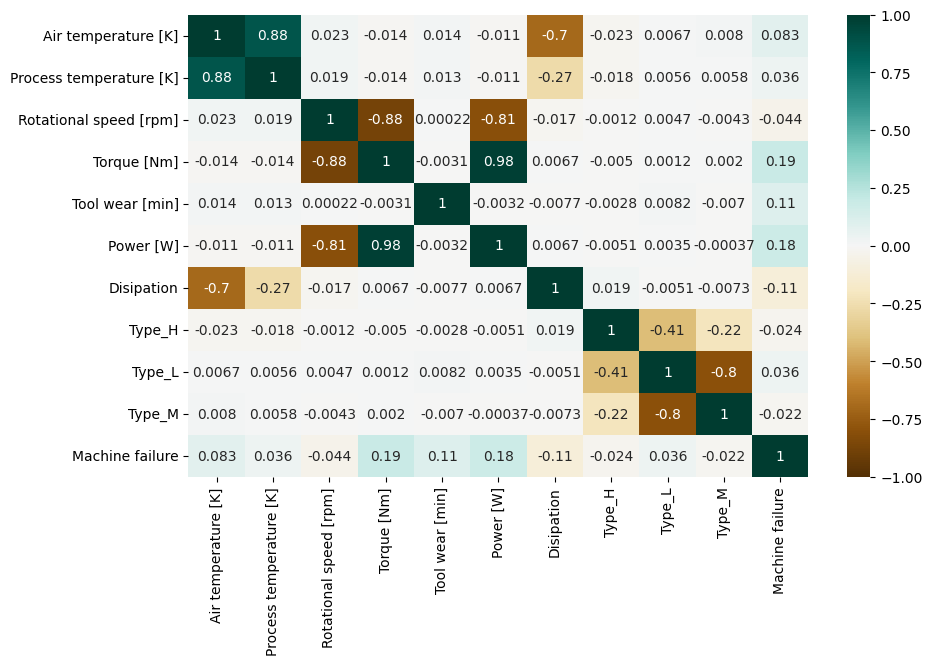

In [28]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop(['TWF','HDF','PWF','OSF'],axis=1).corr(numeric_only=True),annot=True,cmap='BrBG',vmin=-1,vmax=1)

No tenemos valores muy buenos de correlación para el target (Machine Failure), habrá que realizar una tarea de Feature engineering intensa para mejorar estas correlaciones

Vamos a ver lo que muestra la representación de Tool wear, para observar a qué tiempo se producen más fallos

<Axes: xlabel='Tool wear [min]', ylabel='Machine failure'>

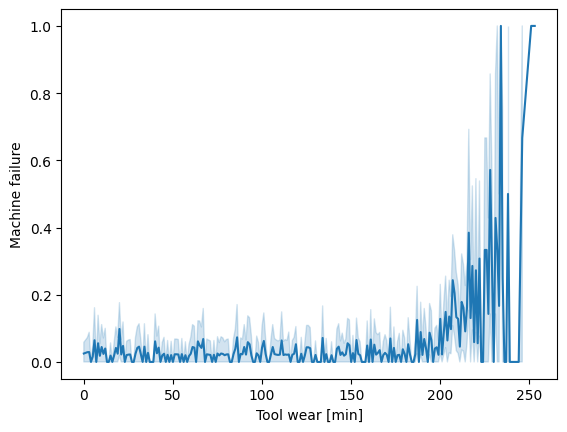

In [29]:
sns.lineplot(x=df['Tool wear [min]'],y=df['Machine failure'])

Aunque hay diferentes valores de 1 a lo largo del tiempo provocando la aletoriedad de la gráfica. Sin embargo, vemos claramente que en los valores altos es donde se producen la mayoría de fallos, lo cual será algo a tener muy en cuenta a la hora de predecir.

## MODELING

In [30]:
X=df.drop(['Product ID','Machine failure','TWF','HDF','PWF','OSF','Power [W]','Disipation'],axis=1)
y=df['Machine failure']

In [31]:
X.head(5)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M
UDI,,,,,,,,
1,298.1,308.6,1551,42.8,0,False,False,True
2,298.2,308.7,1408,46.3,3,False,True,False
3,298.1,308.5,1498,49.4,5,False,True,False
4,298.2,308.6,1433,39.5,7,False,True,False
5,298.2,308.7,1408,40.0,9,False,True,False


Debido a qué tenemos un gran número de 1 más que 0 probaremos a hacer un under sampler posteriormente por si mejora:

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 8)
(2000, 8)
(8000,)
(2000,)


In [33]:
oversampler = RandomOverSampler(random_state=42)
X_over_resampled, y_over_resampled = oversampler.fit_resample(X_train, y_train)

X_over_resampled.shape,y_over_resampled.shape

((15458, 8), (15458,))

In [34]:
undersampler = RandomUnderSampler(random_state=42)
X_under_resampled, y_under_resampled = undersampler.fit_resample(X_train, y_train)

X_under_resampled.shape,y_under_resampled.shape

((542, 8), (542,))

Vamos a ver que obtendriamos considerando toda la muestra con un croos validation y el modelo de logistic regression para intuir con los valores de accuaricy que vamos a trabajar:

In [35]:
results=cross_val_score(LogisticRegression(max_iter=10000),X,y,scoring='roc_auc',cv=10)
results

array([0.97549434, 0.88268786, 0.86511996, 0.83254171, 0.85202777,
       0.83433808, 0.85498112, 0.94257703, 0.91943734, 0.9107904 ])

Para encontrar el mejor modelo aplicaremos un pipeline donde estableceremos una serie de pasos para seleccionar las mejores features, el tipo de estandarización y el tipo de modelo. Para ello nos enfocaremos en el grid search en el recall, para que se ajuste mejor a la hora de predecir cuando rompe la máquina, sin importar tanto los posibles errores al predecirlo (parcilmente sí, ya que podría afectar al tiempo de producción cambiarla tantas veces)

In [ ]:
pipe = Pipeline(steps=[("selectkbest", SelectKBest()),
    ("scaler", StandardScaler()),
    ('classifier', svm.SVC())
])

""" logistic_params = {
    'selectkbest__k': [3,4,5,'all'],
    'classifier': [LogisticRegression(max_iter=10000, solver='liblinear'), LogisticRegression(max_iter=1000, solver='liblinear')],
    'classifier__penalty': ['l1', 'l2']
} """
random_forest_params = {
    'selectkbest__k': [3,4,5,'all'],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [RandomForestClassifier(random_state=100)],
    'classifier__max_depth': [2,3,4]
}

svm_param = {
    'selectkbest__k': [3,4,5,'all'],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [svm.SVC(probability=True, random_state=42)],
    'classifier__C': [ 1, 5, 10, 100],
}

#PROBAR NAIVE BAYES

xgb_param = {
    'classifier': [xgboost.XGBClassifier(random_state=100)],
    #'classifier__n_estimators': [10,20,50,100],
    #'classifier__learning_rate': [0.1,0.5,1],
    'classifier__max_depth': [2,3,4]
}

search_space = [
    #logistic_params,
    random_forest_params,
    svm_param,
    #xgb_param
]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = KFold(10),
                  scoring='recall',
                  verbose=2,
                  n_jobs=-1)


In [37]:
clf.fit(X_train, y_train)
model=clf.best_estimator_
model

Fitting 10 folds for each of 87 candidates, totalling 870 fits


c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.         0.18672387 0.05303405 0.         0.         0.18672387
 0.05303405 0.         0.         0.18672387 0.05303405 0.
 0.05134249 0.2200313  0.19398883 0.07576344 0.05134249 0.2200313
 0.19398883 0.07576344 0.05134249 0.2200313  0.19398883 0.07576344
 0.14791138 0.28045111 0.24894262 0.20206737 0.14791138 0.27687968
 0.24894262 0.20206737 0.14791138 0.28045111 0.24894262 0.20206737
 0.2101251  0.25560027 0.24673862 0.23801942 0.12079124 0.14270567
 0.11870736 0.05172933 0.         0.01363636 0.         0.
 0.30268189 0.36419565 0.39124245 0.41396504 0.23034834 0.23484006
 0.28337222 0.23070327 0.         0.03838384 0.03838384 0.06098258
 0.31620864 0.38254892 0.40662803 0.49104204 0.27889271 0.26460876
 0.3328507  0.28829938 0.         0.03838384 0.03838384 0.06098258
 0.33274206 0.42260446 0.47579049 0.605

Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('scaler', StandardScaler()),
                ('classifier', SVC(C=100, probability=True, random_state=42))])

In [38]:
predictions=model.predict(X_test)
predictions_proba_normal = model.predict_proba(X_test)

In [39]:
pd.DataFrame(index=['accuracy','precision','recall','confusion_matrix','roc_auc'],columns=['results_model'],data=[accuracy_score(y_test, predictions),precision_score(y_test, predictions),recall_score(y_test, predictions),confusion_matrix(y_test,predictions),roc_auc_score(y_test, predictions)])

,results_model
accuracy,0.9785
precision,0.727273
recall,0.588235
confusion_matrix,"[[1917, 15], [28, 40]]"
roc_auc,0.790236


Text(0.5, 1.0, 'Matrix_confusion_normal')

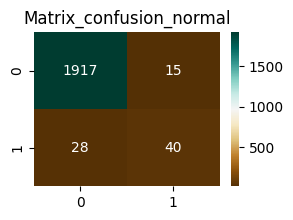

In [40]:
plt.figure(figsize=(3,2))
sns.heatmap(confusion_matrix(y_test,predictions),cmap='BrBG',annot=True,fmt='.0f');
plt.title('Matrix_confusion_normal')


In [41]:
skbest = model.named_steps["selectkbest"]
selected_indices = skbest.get_support(indices=True)
feature_names = X.columns[selected_indices]
print(feature_names)
scores = skbest.scores_  # Puntuaciones de todas las features
print(scores[selected_indices])  # Solo las seleccionadas


Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_H',
       'Type_L', 'Type_M'],
      dtype='object')
[ 59.59532468  13.36805799  12.79574813 299.65269077  79.51017358
   4.94597239  17.827876     9.38729859]


In [42]:
#Esto solo se aplicaría en el caso de obtener un random forest para ver las features importances
""" 
best_pipeline = clf.best_estimator_
# Accede al modelo dentro del pipeline por su nombre
model = best_pipeline.named_steps['classifier']

# Visualiza las importancias de las features en el caso de randomForest
importances = model.feature_importances_ 

#solo si fuera randomforest
pd.DataFrame(index=X_train.columns,data=importances,columns=['Features'])
 """


" \nbest_pipeline = clf.best_estimator_\n# Accede al modelo dentro del pipeline por su nombre\nmodel = best_pipeline.named_steps['classifier']\n\n# Visualiza las importancias de las features en el caso de randomForest\nimportances = model.feature_importances_ \n\n#solo si fuera randomforest\npd.DataFrame(index=X_train.columns,data=importances,columns=['Features'])\n "

Se ha obtenido un resultado, que a primera instancia parece que es bueno pero que al analizarlo vemos que tiene un recall bastante malo, y eso es porque aunque los 0 los predice muy bien, los uno los predice bastante mal, acertando 42 y fallando 26.

Vamos a probar con el modelo resampleado, para que haya tantos 1 como 0:

#### UNDERSAMPLER:

In [43]:
clf.fit(X_under_resampled, y_under_resampled)
model_under_resampled=clf.best_estimator_
model_under_resampled

Fitting 10 folds for each of 87 candidates, totalling 870 fits


c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.47407407 0.35555556 0.46296296 0.45740741 0.47407407 0.35555556
 0.46296296 0.45925926 0.47407407 0.35555556 0.46296296 0.45925926
 0.50555556 0.42777778 0.51481481 0.51111111 0.50555556 0.42777778
 0.51481481 0.51111111 0.50555556 0.42777778 0.51481481 0.51111111
 0.41851852 0.55185185 0.53148148 0.54259259 0.42037037 0.55185185
 0.53333333 0.54259259 0.41851852 0.55185185 0.53333333 0.54259259
 0.5462963  0.5462963  0.51851852 0.52777778 0.5462963  0.54814815
 0.5037037  0.49814815 0.35925926 0.35555556 0.3537037  0.46851852
 0.55555556 0.55       0.53518519 0.5462963  0.46111111 0.54814815
 0.51666667 0.52222222 0.33703704 0.44074074 0.42962963 0.51111111
 0.55740741 0.5537037  0.53888889 0.54074074 0.55185185 0.54444444
 0.52592593 0.52222222 0.34444444 0.34074074 0.43888889 0.50740741
 0.5537037  0.53333333

Pipeline(steps=[('selectkbest', SelectKBest(k=3)), ('scaler', StandardScaler()),
                ('classifier', SVC(C=10, probability=True, random_state=42))])

In [44]:
predictions_under=model_under_resampled.predict(X_test)
predictions_proba_under = model_under_resampled.predict_proba(X_test)

In [45]:
pd.DataFrame(index=['accuracy','precision','recall','confusion_matrix','roc_auc'],columns=['results_model'],data=[accuracy_score(y_test, predictions_under),precision_score(y_test, predictions_under),recall_score(y_test, predictions_under),confusion_matrix(y_test,predictions_under),roc_auc_score(y_test, predictions_under)])

,results_model
accuracy,0.858
precision,0.187861
recall,0.955882
confusion_matrix,"[[1651, 281], [3, 65]]"
roc_auc,0.905219


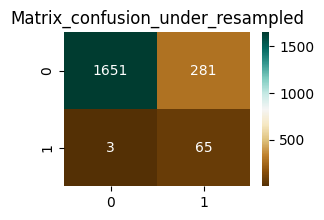

In [46]:
plt.figure(figsize=(3,2))
plt.title('Matrix_confusion_under_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_under),cmap='BrBG', annot=True,fmt='.0f',);

In [47]:
skbest = model_under_resampled.named_steps["selectkbest"]
selected_indices = skbest.get_support(indices=True)
feature_names = X.columns[selected_indices]
print(feature_names)
scores = skbest.scores_  # Puntuaciones de todas las features
print(scores[selected_indices])  # Solo las seleccionadas


Index(['Air temperature [K]', 'Torque [Nm]', 'Tool wear [min]'], dtype='object')
[25.2595668  74.83333703 35.62649038]


El valor que ha dado el modelo a las diferentes features es:

In [48]:
""" #Al ser un randomForest el modelo elegido, valoramos los pesos de las features dado:

best_pipeline = model_under_resampled.best_estimator_
# Accede al modelo dentro del pipeline por su nombre
model = best_pipeline.named_steps['classifier']

# Visualiza las importancias de las features en el caso de randomForest
importances = model.feature_importances_ 

#Creamos un dataframe:
pd.DataFrame(index=X_train.columns,data=importances,columns=['Features']) """

" #Al ser un randomForest el modelo elegido, valoramos los pesos de las features dado:\n\nbest_pipeline = model_under_resampled.best_estimator_\n# Accede al modelo dentro del pipeline por su nombre\nmodel = best_pipeline.named_steps['classifier']\n\n# Visualiza las importancias de las features en el caso de randomForest\nimportances = model.feature_importances_ \n\n#Creamos un dataframe:\npd.DataFrame(index=X_train.columns,data=importances,columns=['Features']) "

#### OVERSAMPLER:

In [49]:
clf.fit(X_over_resampled, y_over_resampled)
model_over_resampled=clf.best_estimator_
model_over_resampled

Fitting 10 folds for each of 87 candidates, totalling 870 fits


c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.83411695 0.78907967 0.77153995 0.76588678 0.83411695 0.78907967
 0.77153995 0.76588678 0.83411695 0.78907967 0.77153995 0.76588678
 0.90020482 0.87160423 0.86257138 0.86177292 0.90020482 0.87160423
 0.86257138 0.86177292 0.90020482 0.87160423 0.86257138 0.86177292
 0.9243821  0.96502328 0.94878973 0.92523611 0.9243821  0.96502328
 0.94878973 0.92523611 0.9243821  0.96502328 0.94878973 0.92523611
 0.94180826 0.94203347 0.94267239 0.96151848 0.94237155 0.90602296
 0.90799292 0.93215009 0.72374047 0.73840555 0.74083467 0.84980079
 0.94712709 0.9470837  0.95868936 0.96598359 0.95272212 0.92181571
 0.91788751 0.94967184 0.80357162 0.78441895 0.76720137 0.85278056
 0.94252641 0.95047671 0.96214885 0.96810629 0.95157017 0.92846731
 0.92183296 0.95863665 0.80904602 0.80749335 0.79722205 0.86720246
 0.9497888  0.95922351

Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('scaler', StandardScaler()),
                ('classifier', SVC(C=100, probability=True, random_state=42))])

In [50]:
predictions_over=model_over_resampled.predict(X_test)
predictions_proba_over = model_over_resampled.predict_proba(X_test)

In [51]:
pd.DataFrame(index=['accuracy','precision','recall','confusion_matrix','roc_auc'],columns=['results_model'],data=[accuracy_score(y_test, predictions_over),precision_score(y_test, predictions_over),recall_score(y_test, predictions_over),confusion_matrix(y_test,predictions_over),roc_auc_score(y_test, predictions_over)])

,results_model
accuracy,0.9425
precision,0.357576
recall,0.867647
confusion_matrix,"[[1826, 106], [9, 59]]"
roc_auc,0.906391


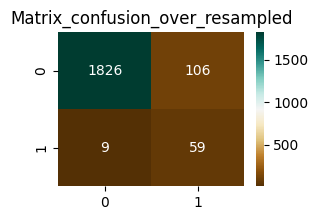

In [52]:
plt.figure(figsize=(3,2))
plt.title('Matrix_confusion_over_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_over),cmap='BrBG', annot=True,fmt='.0f',);

In [53]:
skbest = model_over_resampled.named_steps["selectkbest"]
selected_indices = skbest.get_support(indices=True)
feature_names = X.columns[selected_indices]
print(feature_names)
scores = skbest.scores_  # Puntuaciones de todas las features
print(scores[selected_indices])  # Solo las seleccionadas


Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_H',
       'Type_L', 'Type_M'],
      dtype='object')
[ 770.77300379  171.99814681   73.9359058  2396.89330349  968.54957939
   74.91000652  313.49720875  187.1290987 ]


### ESTADÍSITCAS DE LOS TRES MODELOS:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.73      0.59      0.65        68

    accuracy                           0.98      2000
   macro avg       0.86      0.79      0.82      2000
weighted avg       0.98      0.98      0.98      2000



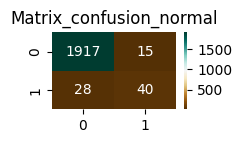

In [54]:
plt.figure(figsize=(2,1))
plt.title('Matrix_confusion_normal')
sns.heatmap(confusion_matrix(y_test,predictions),cmap='BrBG', annot=True,fmt='.0f',);
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1932
           1       0.19      0.96      0.31        68

    accuracy                           0.86      2000
   macro avg       0.59      0.91      0.62      2000
weighted avg       0.97      0.86      0.90      2000



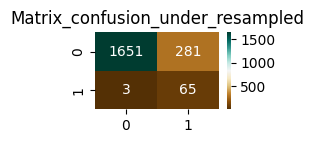

In [55]:
plt.figure(figsize=(2,1))
print(classification_report(y_test, predictions_under))
plt.title('Matrix_confusion_under_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_under),cmap='BrBG', annot=True,fmt='.0f',);

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1932
           1       0.36      0.87      0.51        68

    accuracy                           0.94      2000
   macro avg       0.68      0.91      0.74      2000
weighted avg       0.97      0.94      0.95      2000



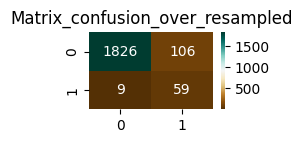

In [56]:
plt.figure(figsize=(2,1))
print(classification_report(y_test, predictions_over))
plt.title('Matrix_confusion_over_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_over),cmap='BrBG', annot=True,fmt='.0f',);

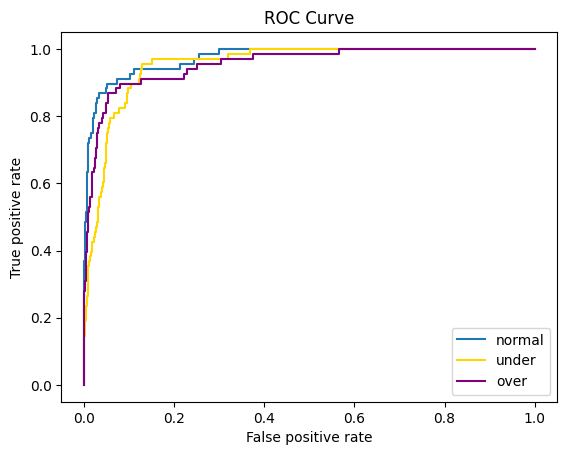

In [57]:
""" 
Roc curve normal data
"""
y_pred_prob = model.predict_proba(X_test)
np.round(y_pred_prob, 2)
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob[:,1])

#Plot the roc curve
plt.plot(fpr,tpr,label='normal')

""" 
Roc curve under resampled
"""

y_pred_prob_under = model_under_resampled.predict_proba(X_test)
np.round(y_pred_prob_under, 2)
fpr_u, tpr_u, threshold_u = roc_curve(y_test, y_pred_prob_under[:,1])

#Plot the roc curve
plt.plot(fpr_u,tpr_u,label='under',color='gold')

""" 
Roc curve over resampled
"""

y_pred_prob_over = model_over_resampled.predict_proba(X_test)
np.round(y_pred_prob_over, 2)
fpr_o, tpr_o, threshold = roc_curve(y_test, y_pred_prob_over[:,1])

#Plot the roc curve
plt.plot(fpr_o,tpr_o,label='over',color='purple')



plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.legend();

In [73]:
input_data = np.array([298.9, 309.1, 2861, 4.6, 143, 0, 1, 0])
input_data = np.expand_dims(input_data, axis=0)  # Cambia la forma a (1, 8)

In [79]:
predict_proba=model_over_resampled.predict_proba(input_data)[0]
predict_proba[1]

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


np.float64(0.9999999999999699)

## ****CONCLUSIÓN:****

En cotraposición al modelo sin rebalancear, los modelos balanceados no nos predicen tan bien los 0 (correcto funcionamiento), ya que algunos los considera como con alta posibilidad de romperse (1), sin embargo los 1 los suele predecir con bastante acierto. ¿Qué nos interesa más? Pues en un primer contexto, a nivel económico parece que el segundo caso, ya que aunque tengamos que parar más veces la máquina ahorraremos en herramientas rotas. Sin embargo, puede que empeore mucho el tiempo de procesado y nuestra producción se vea muy mermada. Por ello, viendo que el modelo de oversampler mejora mucho en los 0 acertados aunque no tan bien en los 0 como el undersampler, nos quedaremos con él, por tener un ratio mejor:

In [58]:
model_over_resampled

Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('scaler', StandardScaler()),
                ('classifier', SVC(C=100, probability=True, random_state=42))])

In [59]:
import pickle

filename = './models/model_normal.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(model, archivo_salida)

In [60]:
import pickle

filename = './models/model_under.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(model_under_resampled, archivo_salida)

In [61]:
import pickle

filename = './models/model_over.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(model_over_resampled, archivo_salida)

Text(0.5, 1.0, 'Matrix_confusion_under_resampled')

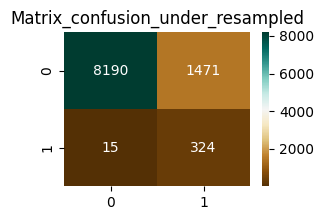

In [62]:
plt.figure(figsize=(3,2))
sns.heatmap(confusion_matrix(y,model_under_resampled.predict(X)),cmap='BrBG', annot=True,fmt='.0f',);
plt.title('Matrix_confusion_under_resampled')

In [80]:
X_test

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M
UDI,,,,,,,,
2998,300.5,309.8,1345,62.7,153,False,True,False
4872,303.7,312.4,1513,40.1,135,False,True,False
3859,302.5,311.4,1559,37.6,209,False,True,False
952,295.6,306.3,1509,35.8,60,True,False,False
6464,300.5,310.0,1358,60.4,102,True,False,False
...,...,...,...,...,...,...,...,...
1687,297.9,307.3,1663,28.7,7,True,False,False
6953,300.8,311.3,1498,40.2,73,False,True,False
9955,298.1,307.9,1446,42.8,121,False,False,True


Text(0.5, 1.0, 'Matrix_confusion_over_resampled')

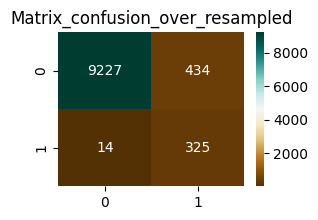

In [63]:
plt.figure(figsize=(3,2))
sns.heatmap(confusion_matrix(y,model_over_resampled.predict(X)),cmap='BrBG', annot=True,fmt='.0f',);
plt.title('Matrix_confusion_over_resampled')

Text(0.5, 1.0, 'Matrix_confusion_normal')

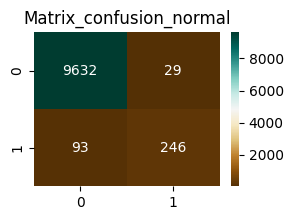

In [64]:
plt.figure(figsize=(3,2))
sns.heatmap(confusion_matrix(y,model.predict(X)),cmap='BrBG', annot=True,fmt='.0f',);
plt.title('Matrix_confusion_normal')

Además viendo la predicción de todos los datos, vemos que el modelo over sampled tiene un mejor rendimiento en todos los aspectos que el under, por lo tanto será con el modelo que nos quedaremos.

### ***SEGUNDO CASO: ESTUDIO DE PREDICCIÓN DE TIPO DE FALLO:***


Qué hago con los modos de fallo (sobre todo con los mixtos)? Es necesario hacer un modelo de machine?

Nos quedamos con el dataframe donde solo se haya prorducido fallo, ya que será con ese donde predeciremos el tipo:

In [65]:
df_type=df[df['Machine failure']==1]

In [66]:
df_type.to_csv('df_type')

In [67]:
df_type.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339 entries, 51 to 9975
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               339 non-null    object 
 1   Air temperature [K]      339 non-null    float64
 2   Process temperature [K]  339 non-null    float64
 3   Rotational speed [rpm]   339 non-null    int64  
 4   Torque [Nm]              339 non-null    float64
 5   Tool wear [min]          339 non-null    int64  
 6   Power [W]                339 non-null    float64
 7   Disipation               339 non-null    float64
 8   Type_H                   339 non-null    bool   
 9   Type_L                   339 non-null    bool   
 10  Type_M                   339 non-null    bool   
 11  Machine failure          339 non-null    int64  
 12  TWF                      339 non-null    int64  
 13  HDF                      339 non-null    int64  
 14  PWF                      339 

In [68]:
df_type.head()

,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Power [W],Disipation,Type_H,Type_L,Type_M,Machine failure,TWF,HDF,PWF,OSF
UDI,,,,,,,,,,,,,,,,
51,L47230,298.9,309.1,2861,4.6,143,1378.174809,10.2,False,True,False,1,0,0,1,0
70,L47249,298.9,309.0,1410,65.7,191,9700.923955,10.1,False,True,False,1,0,0,1,1
78,L47257,298.8,308.9,1455,41.3,208,6292.767165,10.1,False,True,False,1,1,0,0,0
161,L47340,298.4,308.2,1282,60.7,216,8149.019072,9.8,False,True,False,1,0,0,0,1
162,L47341,298.3,308.1,1412,52.3,218,7733.302588,9.8,False,True,False,1,0,0,0,1
